<a href="https://colab.research.google.com/github/Redbricck/HelloGitHub/blob/master/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from torch.autograd import grad
import time






In [13]:
class PhysicsInformedNN:
    def __init__(self, X, u, layers, lb, ub):
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)

        self.x = torch.tensor(X[:, 0:1], dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(X[:, 1:2], dtype=torch.float32, requires_grad=True)
        self.u = torch.tensor(u, dtype=torch.float32)

        self.lambda_1 = torch.tensor([0.0], requires_grad=True, dtype=torch.float32)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True, dtype=torch.float32)

        self.layers = layers
        self.model = self.build_model(layers)

        self.optimizer = torch.optim.Adam(list(self.model.parameters()) + [self.lambda_1, self.lambda_2], lr=1e-3)

    def build_model(self, layers):
        model = torch.nn.Sequential().to(device)
        for i in range(len(layers) - 2):
            model.add_module(f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1]))
            model.add_module(f"tanh_{i}", torch.nn.Tanh())
        model.add_module(f"layer_{len(layers) - 2}", torch.nn.Linear(layers[-2], layers[-1]))
        return model

    def net_u(self, x, t):
        X = torch.cat([x, t], dim=1)
        u = self.model(X)
        return u

    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    def loss_function(self, u_pred, u_true, f_pred):
        mse_u = torch.mean((u_true - u_pred)**2)
        mse_f = torch.mean(f_pred**2)
        return mse_u + mse_f

    def train(self, nIter):
        start_time = time.time()
        for it in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = self.loss_function(u_pred, self.u, f_pred)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if it % 10 == 0:
                elapsed = time.time() - start_time
                lambda_1_value = self.lambda_1.item()
                lambda_2_value = torch.exp(self.lambda_2).item()
                print(f"It: {it}, Loss: {loss.item():.3e}, Lambda_1: {lambda_1_value:.3f}, Lambda_2: {lambda_2_value:.6f}, Time: {elapsed:.2f}")
                start_time = time.time()

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], requires_grad=True, dtype=torch.float32)
        t_star = torch.tensor(X_star[:, 1:2], requires_grad=True, dtype=torch.float32)
        u_star = self.net_u(x_star, t_star)
        f_star = self.net_f(x_star, t_star)
        return u_star.detach().numpy(), f_star.detach().numpy()







In [41]:
def plot_results(model, X_star, x, t, Exact, X_u_train, u_train):
    # Predict using the trained model
    u_pred, f_pred = model.predict(X_star)

    # Reshape predictions to match the shape of Exact solution
    X_grid, T_grid = np.meshgrid(x, t)  # Create a 2D grid of x and t

    # Make sure that x, t, and u_pred are appropriately flattened or reshaped
    U_pred = griddata(X_star, u_pred.flatten(), (X_grid, T_grid), method='cubic')

    # Ensure the shapes of U_pred and Exact match
    if U_pred.shape != Exact.shape:
        U_pred = U_pred[:Exact.shape[0], :Exact.shape[1]]

    lambda_1_value = model.lambda_1.item()
    lambda_2_value = torch.exp(model.lambda_2).item()

    # Plot u(t,x)
    fig, ax = plt.subplots()
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', markersize=1, clip_on=False)
    #ax.plot(X_u_train[:,1], X_u_train[:,0], clip_on=False)
    plt.colorbar(h)

    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('$u(t,x)$')
    #plt.show()
    # Save the figure
    #plt.savefig('u_t_x_plot.png', dpi=600)
    #plt.close()  # Close the figure to avoid display issues
    # Plot slices of u(t,x) at different times
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Time slices for Exact and Predicted data
    slices = [25, 50, 75]

    for i, slice in enumerate(slices):
        axs[i].plot(x, Exact[slice, :], 'b-', linewidth=2, label='Exact')
        axs[i].plot(x, U_pred[slice, :], 'r--', linewidth=2, label='Prediction')
        axs[i].set_title(f'$t = {t[slice][0]:.2f}$')
        axs[i].set_xlabel('$x$')
        axs[i].set_ylabel('$u(t,x)$')

    for ax in axs:
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([Exact.min(), Exact.max()])
        ax.legend()

    plt.tight_layout()
    # Save the figure
    #plt.savefig('u_slices_plot.png', dpi=600)
    #plt.close()  # Close the figure to avoid display issues


In [3]:
# Device diagnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
torch.manual_seed(42)
np.random.seed(42)
# Main execution
if __name__ == "__main__":
    nu = 0.01 / np.pi

    N_u = 2000
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

    data = scipy.io.loadmat('burgers_shock.mat')

    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = np.real(data['usol']).T

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]

    lb = X_star.min(0)
    ub = X_star.max(0)

    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx, :]
    u_train = u_star[idx, :]

    model = PhysicsInformedNN(torch.tensor(X_u_train, dtype=torch.float32),
                              torch.tensor(u_train, dtype=torch.float32),
                              layers, lb, ub)
    model.train(10000)



<ipython-input-8-0e56ebae4d54>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(X[:, 0:1], dtype=torch.float32, requires_grad=True)
<ipython-input-8-0e56ebae4d54>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(X[:, 1:2], dtype=torch.float32, requires_grad=True)
<ipython-input-8-0e56ebae4d54>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(u, dtype=torch.float32)


It: 0, Loss: 3.747e-01, Lambda_1: 0.000, Lambda_2: 0.002480, Time: 0.02
It: 10, Loss: 3.596e-01, Lambda_1: -0.009, Lambda_2: 0.002498, Time: 0.19
It: 20, Loss: 3.032e-01, Lambda_1: -0.018, Lambda_2: 0.002521, Time: 0.19
It: 30, Loss: 2.397e-01, Lambda_1: -0.015, Lambda_2: 0.002550, Time: 0.22
It: 40, Loss: 2.224e-01, Lambda_1: -0.020, Lambda_2: 0.002583, Time: 0.20
It: 50, Loss: 2.045e-01, Lambda_1: -0.032, Lambda_2: 0.002609, Time: 0.20
It: 60, Loss: 1.775e-01, Lambda_1: -0.041, Lambda_2: 0.002630, Time: 0.19
It: 70, Loss: 1.435e-01, Lambda_1: -0.044, Lambda_2: 0.002620, Time: 0.19
It: 80, Loss: 1.158e-01, Lambda_1: -0.032, Lambda_2: 0.002575, Time: 0.19
It: 90, Loss: 1.016e-01, Lambda_1: -0.013, Lambda_2: 0.002523, Time: 0.21
It: 100, Loss: 9.310e-02, Lambda_1: 0.009, Lambda_2: 0.002468, Time: 0.21
It: 110, Loss: 8.077e-02, Lambda_1: 0.031, Lambda_2: 0.002416, Time: 0.29
It: 120, Loss: 6.497e-02, Lambda_1: 0.049, Lambda_2: 0.002372, Time: 0.29
It: 130, Loss: 5.247e-02, Lambda_1: 0.06

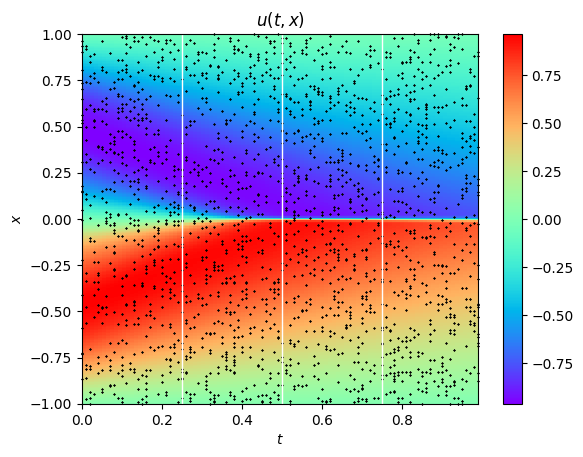

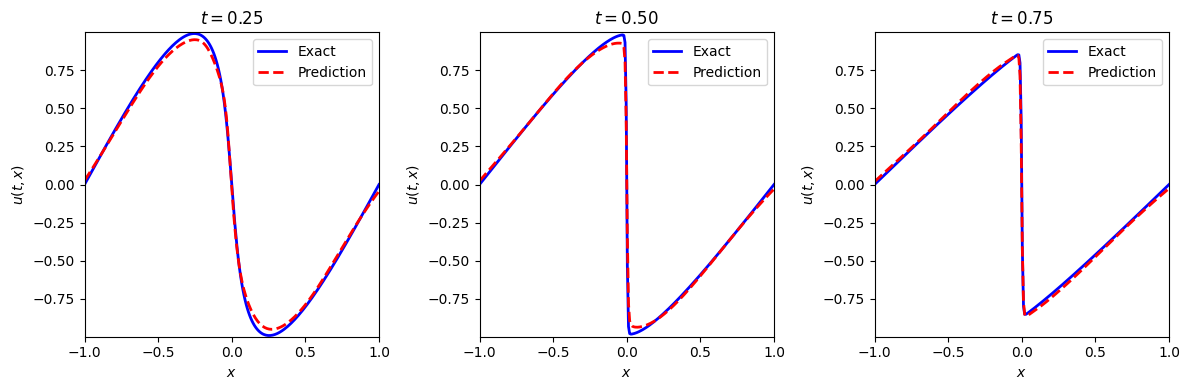

In [42]:
plot_results(model, X_star, x, t, Exact, X_u_train, u_train)